In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from DoS_estimation import dos_estimation
from hellinger_distance import hellinger_distance

In [2]:
#set DoS range and levels
energy_max = 1
energy_min = 0
energy_level = 1000

dos_est = dos_estimation(energy_max, energy_min, energy_level)

In [3]:
#Calculate true DoS
with open('true_distribution_df_range21.pickle', 'rb') as p:
    true_distribution_df = pickle.load(p)

true_dos = dos_est.dos_from_true(true_distribution_df['Total_failure'])

In [4]:
#Estimation of DoS from random samples
with open('random_sampling_range21.pickle', 'rb') as p:
    random_sampling_df = pickle.load(p)
    
random_dos_list = []
trial_num = 5

for trial in range(trial_num):
    energy_data = random_sampling_df[random_sampling_df['trial']==trial]['Total_failure']
    random_dos = dos_est.dos_from_random(energy_data)
    random_dos_list.append(random_dos)

In [5]:
#Estimation of DoS from EPA
with open('EPA_sampling_range21.pickle', 'rb') as p:
    EPA_sampling_df = pickle.load(p)

bnum = 10                                          #number of inverse temperatures
betas = np.linspace(0.1,20,num=bnum)               #inverse temperatures
trial_num = 5                                      #number of trial
mhm_iter = 100                                     #iteration of multiple histogram method
energy_column = 'Total_failure'                    #dos target outputs (outputs used for epa optimization)

EPA_dos_list = []
EPA_f_list = []

for trial in range(trial_num):
    EPA_samples = EPA_sampling_df[EPA_sampling_df['trial']==trial]
    EPA_dos, EPA_f = dos_est.dos_from_epa(betas, EPA_samples, energy_column, mhm_iter)
    EPA_dos_list.append(EPA_dos)
    EPA_f_list.append(EPA_f)

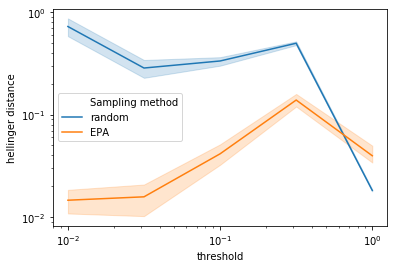

In [6]:
thres_list = [10**value for value in np.arange(-2,0.1,0.5)]       #energy threshold point for Hellinger comparison

hg = hellinger_distance(true_dos)
rs_hellinger_df = hg.hellinger_for_plot(random_dos_list, thres_list) #Hellinger distance of DoS by random samples
es_hellinger_df = hg.hellinger_for_plot(EPA_dos_list, thres_list)    #Hellinger distance of DoS by EPA

rs_hellinger_df['Sampling method'] = 'random'
es_hellinger_df['Sampling method'] = 'EPA'
helinger_compare_df = pd.concat((rs_hellinger_df,es_hellinger_df))
helinger_compare_df = pd.melt(helinger_compare_df, id_vars='Sampling method', var_name='threshold', value_name='hellinger distance')
sns.lineplot(data=helinger_compare_df, x="threshold", y="hellinger distance", hue="Sampling method", markers=True)
plt.xscale('log')
plt.yscale('log')
plt.show()